###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

###### Translated by Huizhe Di @ SCSIO

# 变形的笛卡尔四网格通过超限插值


正如我们在上一课中看到的那样，当需要地层界面的精确近似时，等距笛卡尔网格有一些严重的局限性。一种可能的解决方案是变形的笛卡尔四网格，它通常用于谱元法的框架中，我们将在后面的讲座中介绍。我想用我目前正在研究的一个例子来说明这个问题。

## 问题: 具有强烈地形变化的Sea Dike

我将全波形反演 (FWI) 应用到 SH-data acquired on a sea dike at the west coast of Schleswig-Holstein in Northern Germany ([Köhn et al. 2018](https://www.researchgate.net/publication/324138422_Sea_dike_evaluation_by_SH_full_waveform_inversion)). 为了避免有限差分正向建模代码中使用的具有强形貌的自由曲面的笛卡尔网格离散化问题，模型和采集几何图形根据地形旋转，并将 FWI 应用于具有平面自由曲面的模型。最后，FWI 结果相对于真实的海堤地形旋转回来。由此产生的Vs模型显示了一些高速和低速层（图1），这些层可能与通过钻孔剖面验证的沙子和海洋粘土层有关。

<img src="images/tumlauk_deich_FWI.jpg" width="90%">

*Fig. 1 FWI results for the land- and sea-side of the Tümlauer Koog sea dike (from [Köhn et al. 2018](https://www.researchgate.net/publication/324138422_Sea_dike_evaluation_by_SH_full_waveform_inversion)).*

这种方法的缺点是，我们不能使用在堤坝的整个长度上获取的完整数据集，而必须将FWI限制在堤坝倾斜表面上的源和接收器上。
因此，我们希望用谱元法替换有限差分，该方法可以使用规则的变形四网格处理模型离散化。

## 超限插值 

我们想要将逻辑域中在单位 sqare 上定义的笛卡尔网格 $(\xi,\eta)$ 映射到物理域 $(x,z)$, 其中笛卡尔网格变形:


<img src="images/TFI_concept.png" width="100%">

网格的变形由边界曲线描述 $\vec{x}_t$, $\vec{x}_b$, $\vec{x}_l$ and $\vec{x}_r$. 计算物理域内变形的四核像元，我们使用 **超限插值 (TFI)**. 超限插值可参考 ([Gordon and Hall, 1973 ](https://onlinelibrary.wiley.com/doi/abs/10.1002/nme.1620070405)) 用的是一阶**拉格朗日多项式** $1-\xi$, $\xi$, $1-\eta$ and $\eta$ 作为基本超限插值公式中的混合函数:

\begin{align}
\vec{x}(\xi,\eta) & = (1-\eta)\vec{x}_b(\xi) + \eta \vec{x}_t(\xi) + (1-\xi)\vec{x}_l(\eta)+\xi\vec{x}_r(\eta)\nonumber\\
&-\{\xi\eta\vec{x}_t(1)+\xi(1-\eta)\vec{x}_b(1)\nonumber\\
&+\eta(1-\xi)\vec{x}_t(0)+(1-\xi)(1-\eta)\vec{x}_b(0),\nonumber
\end{align}

这里 $\vec{x}=(x,z)$. 更多细节, 我参考了书籍 [The Fundamentals of Grid Generation](https://www.researchgate.net/publication/265361548_The_Fundamentals_of_Grid_Generation) by Patrick M. Knupp and Stanly Steinberg. Let's try to reproduce an example from the book denoted as "The Swan". 

In [1]:
# Import Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Here, I introduce a new library, which is useful 
# to define the fonts and size of a figure in a notebook
from pylab import rcParams

# Get rid of a Matplotlib deprecation warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define parameters for deformed Cartesian mesh
NX = 20
NZ = 20

In [3]:
# Define parametric curves at model boundaries ...
# ... bottom boundary
def Xb(s):
    
    x = s
    z = 0.0

    xzb = [x,z]
    
    return xzb

# ... top boundary
def Xt(s):
    
    x = s
    z = 1 - 3 * s + 3 * s**2    

    xzt = [x,z]
    
    return xzt

# ... left boundary
def Xl(s):
    
    x = 0.0
    z = s  

    xzl = [x,z]
    
    return xzl

# ... right boundary
def Xr(s):
    
    x = 1 + 2 * s - 2 * s**2
    z = s
    
    xzr = [x,z]
    
    return xzr

In [4]:
# Transfinite interpolation

# Discretize along xi and eta axis
xi = np.linspace(0.0, 1.0, num=NX)
eta = np.linspace(0.0, 1.0, num=NZ)

xi1, eta1 = np.meshgrid(xi, eta)

# Intialize matrices for x and z axis
X = np.zeros((NX,NZ))
Z = np.zeros((NX,NZ))

# loop over cells
for i in range(NX):
    Xi = xi[i]
    for j in range(NZ):
        Eta = eta[j]
        
        # evaluate parametric curves
        xb = Xb(Xi)
        xb0 = Xb(0)
        xb1 = Xb(1)
        
        xt = Xt(Xi)
        xt0 = Xt(0)
        xt1 = Xt(1)
        
        xl = Xl(Eta)
        xr = Xr(Eta)

        # Transfinite Interpolation (Gordon-Hall algorithm)
        X[i,j] = (1-Eta) * xb[0] + Eta * xt[0] + (1-Xi) * xl[0] + Xi * xr[0] \
               - (Xi * Eta * xt1[0] + Xi * (1-Eta) * xb1[0] + Eta * (1-Xi) * xt0[0] \
               + (1-Xi) * (1-Eta) * xb0[0])
            
        Z[i,j] = (1-Eta) * xb[1] + Eta * xt[1] + (1-Xi) * xl[1] + Xi * xr[1] \
               - (Xi * Eta * xt1[1] + Xi * (1-Eta) * xb1[1] + Eta * (1-Xi) * xt0[1] \
               + (1-Xi) * (1-Eta) * xb0[1])        

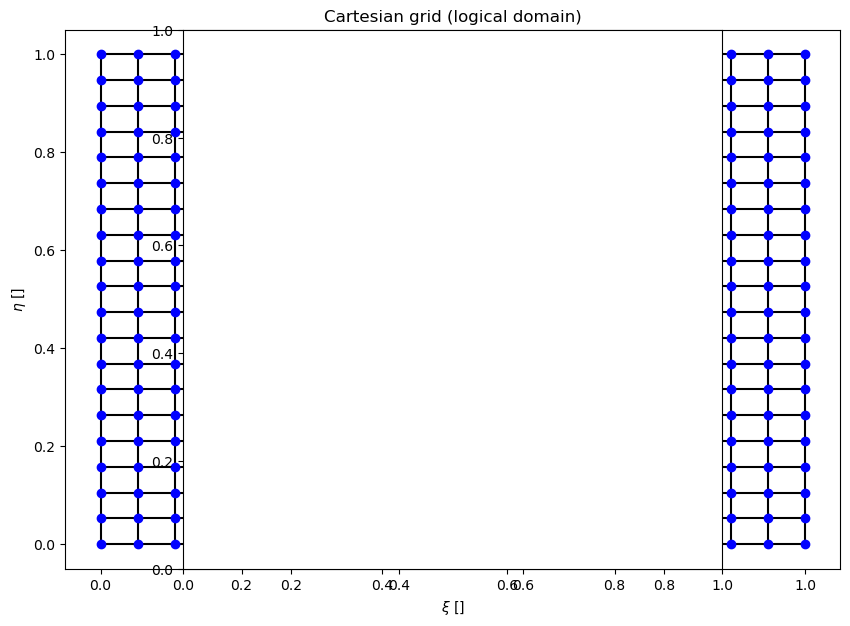

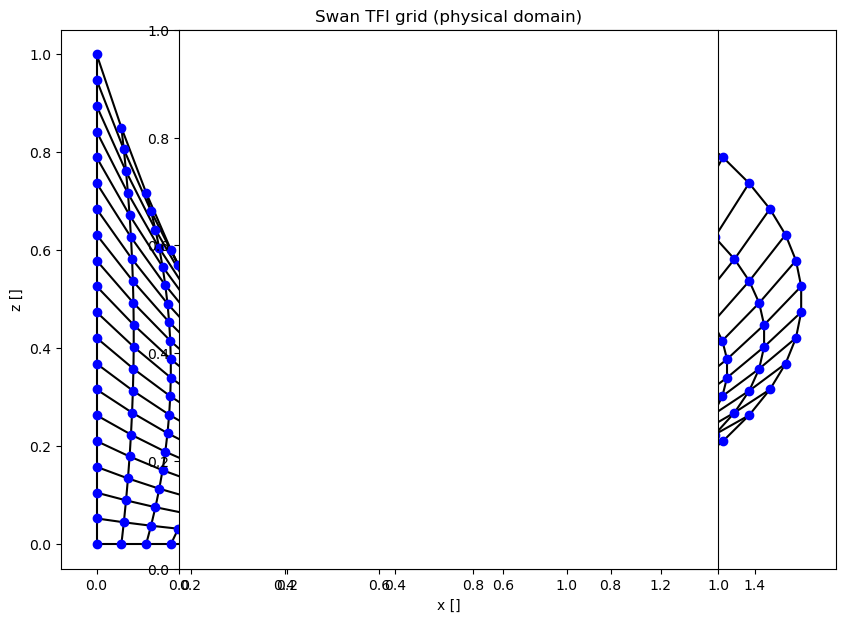

In [5]:
# Define figure size
rcParams['figure.figsize'] = 10, 7

# Plot TFI mesh (physical domain)
plt.plot(xi1, eta1, 'k')
plt.plot(xi1.T, eta1.T, 'k')

# Plot grid points
plt.plot(xi1, eta1, 'bo')

plt.title("Cartesian grid (logical domain)" )
plt.xlabel(r"$\xi$ []")
plt.ylabel(r"$\eta$ []")
plt.axes().set_aspect('equal')
plt.show()

# Plot TFI mesh (physical domain)
plt.plot(X, Z, 'k')
plt.plot(X.T, Z.T, 'k')

# Plot grid points
plt.plot(X, Z, 'bo')

plt.title("Swan TFI grid (physical domain)" )
plt.xlabel("x []")
plt.ylabel("z []")
plt.axes().set_aspect('equal')
#plt.savefig('vp_sine1.pdf', bbox_inches='tight', format='pdf')
plt.show()

实现的超限插值似乎工作正常，所以我们可以在下一课看看sea dike的问题

## 我们学习到:
* 如何一个笛卡尔网格可以通过超限插值进行变形
* 如何实现超限插值
* 如何将笛卡尔网格折叠成数字天鹅. 描述了模拟天鹅的折叠过程 [here](http://www.origami-instructions.com/origami-swan.html)